# Fastag Fraud Detection Project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    VotingClassifier,
    BaggingClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
warnings.filterwarnings('ignore')

### Load the dataset

In [2]:
df=pd.read_csv('FastagFraudDetection.csv')

In [3]:
df.head()

,Transaction_ID,Timestamp,Vehicle_Type,FastagID,TollBoothID,Lane_Type,Vehicle_Dimensions,Transaction_Amount,Amount_paid,Geographical_Location,Vehicle_Speed,Vehicle_Plate_Number,Fraud_indicator
0,1,1/6/2023 11:20,Bus,FTG-001-ABC-121,A-101,Express,Large,350,120,"13.059816123454882, 77.77068662374292",65,KA11AB1234,Fraud
1,2,1/7/2023 14:55,Car,FTG-002-XYZ-451,B-102,Regular,Small,120,100,"13.059816123454882, 77.77068662374292",78,KA66CD5678,Fraud
2,3,1/8/2023 18:25,Motorcycle,NaN,D-104,Regular,Small,0,0,"13.059816123454882, 77.77068662374292",53,KA88EF9012,Not Fraud
3,4,1/9/2023 2:05,Truck,FTG-044-LMN-322,C-103,Regular,Large,350,120,"13.059816123454882, 77.77068662374292",92,KA11GH3456,Fraud
4,5,1/10/2023 6:35,Van,FTG-505-DEF-652,B-102,Express,Medium,140,100,"13.059816123454882, 77.77068662374292",60,KA44IJ6789,Fraud


In [4]:
df.shape

(5000, 13)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Transaction_ID         5000 non-null   int64 
 1   Timestamp              5000 non-null   object
 2   Vehicle_Type           5000 non-null   object
 3   FastagID               4451 non-null   object
 4   TollBoothID            5000 non-null   object
 5   Lane_Type              5000 non-null   object
 6   Vehicle_Dimensions     5000 non-null   object
 7   Transaction_Amount     5000 non-null   int64 
 8   Amount_paid            5000 non-null   int64 
 9   Geographical_Location  5000 non-null   object
 10  Vehicle_Speed          5000 non-null   int64 
 11  Vehicle_Plate_Number   5000 non-null   object
 12  Fraud_indicator        5000 non-null   object
dtypes: int64(4), object(9)
memory usage: 507.9+ KB


In [6]:
for col in df:
    print(f"{col}: {df[col].unique()[:2]}")

Transaction_ID: [1 2]
Timestamp: ['1/6/2023 11:20' '1/7/2023 14:55']
Vehicle_Type: ['Bus ' 'Car']
FastagID: ['FTG-001-ABC-121' 'FTG-002-XYZ-451']
TollBoothID: ['A-101' 'B-102']
Lane_Type: ['Express' 'Regular']
Vehicle_Dimensions: ['Large' 'Small']
Transaction_Amount: [350 120]
Amount_paid: [120 100]
Geographical_Location: ['13.059816123454882, 77.77068662374292'
 '13.042660878688794, 77.47580097259879']
Vehicle_Speed: [65 78]
Vehicle_Plate_Number: ['KA11AB1234' 'KA66CD5678']
Fraud_indicator: ['Fraud' 'Not Fraud']


### Data Type Conversion List:

- **Transaction_ID**: `int64` to `int64`
- **Timestamp**: `object` to `datetime64`
- **Vehicle_Type**: `object` to `category`
- **FastagID**: `object` to `category`
- **TollBoothID**: `object` to `category`
- **Lane_Type**: `object` to `category`
- **Vehicle_Dimensions**: `object` to `category`
- **Transaction_Amount**: `int64` to `int64`
- **Amount_paid**: `int64` to `int64`
- **Geographical_Location**: `object` to `object`
- **Vehicle_Speed**: `int64` to `int64`
- **Vehicle_Plate_Number**: `object` to `category`
- **Fraud_indicator**: `object` to `category`

In [7]:
df.duplicated().sum()

0

In [8]:
df.isnull().sum()

Transaction_ID             0
Timestamp                  0
Vehicle_Type               0
FastagID                 549
TollBoothID                0
Lane_Type                  0
Vehicle_Dimensions         0
Transaction_Amount         0
Amount_paid                0
Geographical_Location      0
Vehicle_Speed              0
Vehicle_Plate_Number       0
Fraud_indicator            0
dtype: int64

<Axes: >

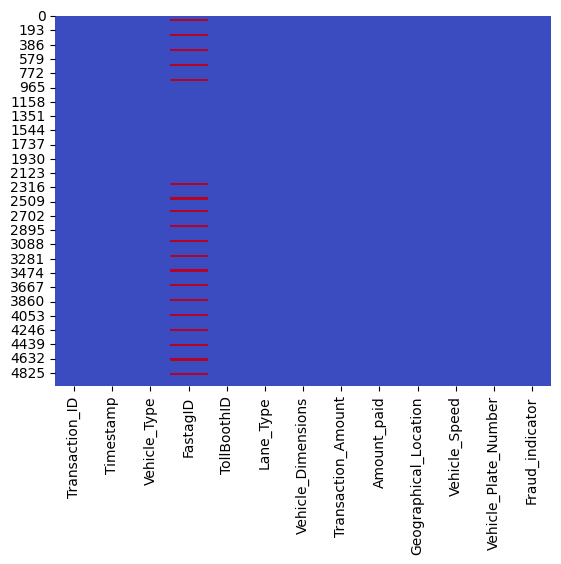

In [9]:
sns.heatmap(df.isnull(),cmap='coolwarm', cbar=False)

In [10]:
print(df[df.isnull().any(axis=1)]['Fraud_indicator'].unique())
print(df[df.isnull().any(axis=1)]['Amount_paid'].unique())
print(df[df.isnull().any(axis=1)]['Transaction_Amount'].unique())
print(df[df.isnull().any(axis=1)]['Vehicle_Dimensions'].unique())
print(df[df.isnull().any(axis=1)]['TollBoothID'].unique())
print(df[df.isnull().any(axis=1)]['Vehicle_Type'].unique())
print(df[df.isnull().any(axis=1)]['Fraud_indicator'].unique())
print(df[df.isnull().any(axis=1)]['Lane_Type'].unique())

['Not Fraud']
[0]
[0]
['Small']
['D-104' 'D-105' 'D-106']
['Motorcycle']
['Not Fraud']
['Regular']


### Observations of NaN Values:
1. **Fraud Indicator**: Only 'Not Fraud' transactions have NaN values.
2. **Transaction Amount and Amount Paid**: Transactions with NaN values have `0` in these columns.
3. **Vehicle Type**: Only 'Motorcycle' entries have NaN values in `FastagID`.

### Reason for NaN Values:
The main reason for NaN values in the `FastagID` column is that motorcycles are not required to use FASTag. As per the reference, two-wheelers are generally exempt from paying tolls on highways across India, and there is no official process to obtain a FASTag for bikes or scooters.

### Reference:
"Is FASTag applicable for bikes? Currently, FASTag is not applicable for bikes as two-wheelers are generally exempt from paying tolls on highways across India. How do you get a FASTag for a two-wheeler? As two-wheelers are not required to pay tolls, there is no official process to obtain a FASTag for bikes or scooters."
Source: [Bajaj Finserv](https://www.bajajfinserv.in/fastag-for-two-wheeler#:~:text=Is%20FASTag%20applicable%20for%20bikes,FASTag%20for%20bikes%20or%20scooters)

### Adjustments to Dataset:
Dropping rows with missing values can be a suitable option in this scenario, given that the missing FastagID values are not needed for motorcycles because they are not required to use FASTag.

### Check Data is Balanced or not?

In [11]:
df['Fraud_indicator'].value_counts()

Fraud_indicator
Not Fraud    4017
Fraud         983
Name: count, dtype: int64

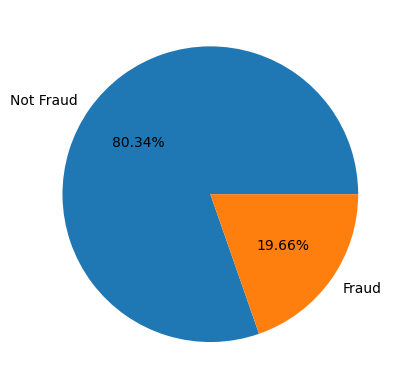

In [12]:
plt.pie(x=df['Fraud_indicator'].value_counts().values,labels=df['Fraud_indicator'].value_counts().index,autopct="%1.2f%%")
plt.show()

The dataset is imbalanced because the number of "Not Fraud" instances significantly outweighs the number of "Fraud" instances. In classification tasks, an imbalanced dataset can bias the model towards the majority class. It's important to address this imbalance to improve the performance of the fraud detection model.

- SMOTE (Synthetic Minority Over-sampling Technique): Generate synthetic instances of the minority class.

Removing NAN Value:

In [7]:
df.dropna(inplace=True)

In [8]:
df.isnull().sum()

Transaction_ID           0
Timestamp                0
Vehicle_Type             0
FastagID                 0
TollBoothID              0
Lane_Type                0
Vehicle_Dimensions       0
Transaction_Amount       0
Amount_paid              0
Geographical_Location    0
Vehicle_Speed            0
Vehicle_Plate_Number     0
Fraud_indicator          0
dtype: int64

### Reason For Fraud:

In [15]:
df_bike=df[df['Vehicle_Type']=='Motorcycle']

I separate the motorcycle data for further analysis because, in real-world scenarios, FASTag cards are not used for motorcycles.

In [16]:
df=df[df['Vehicle_Type']!='Motorcycle']

In [17]:
print(df.groupby('Fraud_indicator')['Vehicle_Type'].unique())
print(df.groupby('Fraud_indicator')['TollBoothID'].unique())
print(df.groupby('Fraud_indicator')['Lane_Type'].unique())
print(df.groupby('Fraud_indicator')['Vehicle_Dimensions'].unique())
print(df.groupby('Fraud_indicator')['Transaction_ID'].mean())
print(df.groupby('Fraud_indicator')['Transaction_Amount'].mean())
print(df.groupby('Fraud_indicator')['Amount_paid'].mean())
print(df.groupby('Fraud_indicator')['Vehicle_Speed'].mean())

Fraud_indicator
Fraud        [Bus , Car, Truck, Van, Sedan, SUV]
Not Fraud    [SUV, Sedan, Bus , Van, Car, Truck]
Name: Vehicle_Type, dtype: object
Fraud_indicator
Fraud        [A-101, B-102, C-103]
Not Fraud    [B-102, A-101, C-103]
Name: TollBoothID, dtype: object
Fraud_indicator
Fraud        [Express, Regular]
Not Fraud    [Regular, Express]
Name: Lane_Type, dtype: object
Fraud_indicator
Fraud        [Large, Small, Medium]
Not Fraud    [Large, Medium, Small]
Name: Vehicle_Dimensions, dtype: object
Fraud_indicator
Fraud        2019.330621
Not Fraud    2644.024220
Name: Transaction_ID, dtype: float64
Fraud_indicator
Fraud        193.555443
Not Fraud    186.207993
Name: Transaction_Amount, dtype: float64
Fraud_indicator
Fraud         92.838250
Not Fraud    186.207993
Name: Amount_paid, dtype: float64
Fraud_indicator
Fraud        68.340793
Not Fraud    67.745988
Name: Vehicle_Speed, dtype: float64


The main reason for fraud in Fastag transactions appears to be the significant discrepancy between the transaction amount and the amount paid, indicating underpayment or possible non-payment of toll fees. This discrepancy suggests that vehicles involved in fraudulent transactions are not paying the full toll amount required.

Proof

In [18]:
df[df['Fraud_indicator']=='Fraud'].sample(2)

,Transaction_ID,Timestamp,Vehicle_Type,FastagID,TollBoothID,Lane_Type,Vehicle_Dimensions,Transaction_Amount,Amount_paid,Geographical_Location,Vehicle_Speed,Vehicle_Plate_Number,Fraud_indicator
1581,1582,3/26/2023 20:30,SUV,FTG-955-BCD-901,B-102,Regular,Large,140,100,"12.936687032945434, 77.53113977439017",65,KA68QR4567,Fraud
104,105,4/20/2023 12:20,SUV,FTG-125-LMN-669,B-102,Express,Large,180,100,"13.059816123454882, 77.77068662374292",63,KA16MN0123,Fraud


In [19]:
df[df['Fraud_indicator']=='Not Fraud'].sample(2)

,Transaction_ID,Timestamp,Vehicle_Type,FastagID,TollBoothID,Lane_Type,Vehicle_Dimensions,Transaction_Amount,Amount_paid,Geographical_Location,Vehicle_Speed,Vehicle_Plate_Number,Fraud_indicator
2378,2379,7/3/2023 22:30,Sedan,FTG-338-LHJ-876,A-101,Express,Medium,115,115,"13.21331620748757, 77.55413526894684",53,GA16ST7890,Not Fraud
3518,3519,9/7/2023 11:22,Truck,FTG-872-QAZ-654,C-103,Express,Large,340,340,"12.84197701525119, 77.67547528176169",62,KA23WX5878,Not Fraud


<Axes: xlabel='Amount_paid', ylabel='Transaction_Amount'>

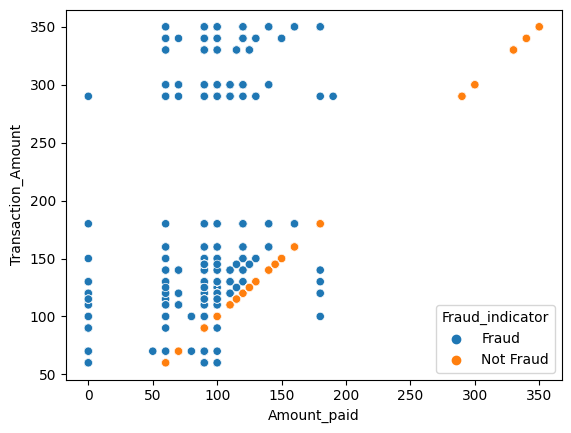

In [20]:
sns.scatterplot(data=df,x='Amount_paid',y='Transaction_Amount',hue='Fraud_indicator')

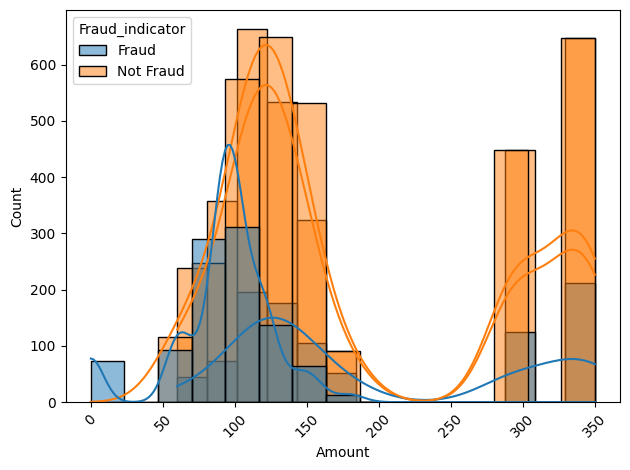

In [21]:
sns.histplot(data=df, x='Transaction_Amount', hue='Fraud_indicator',kde=True)
sns.histplot(data=df, x='Amount_paid', hue='Fraud_indicator',kde=True,)
plt.xticks(rotation=45)
plt.xlabel('Amount')
plt.tight_layout()
plt.show()

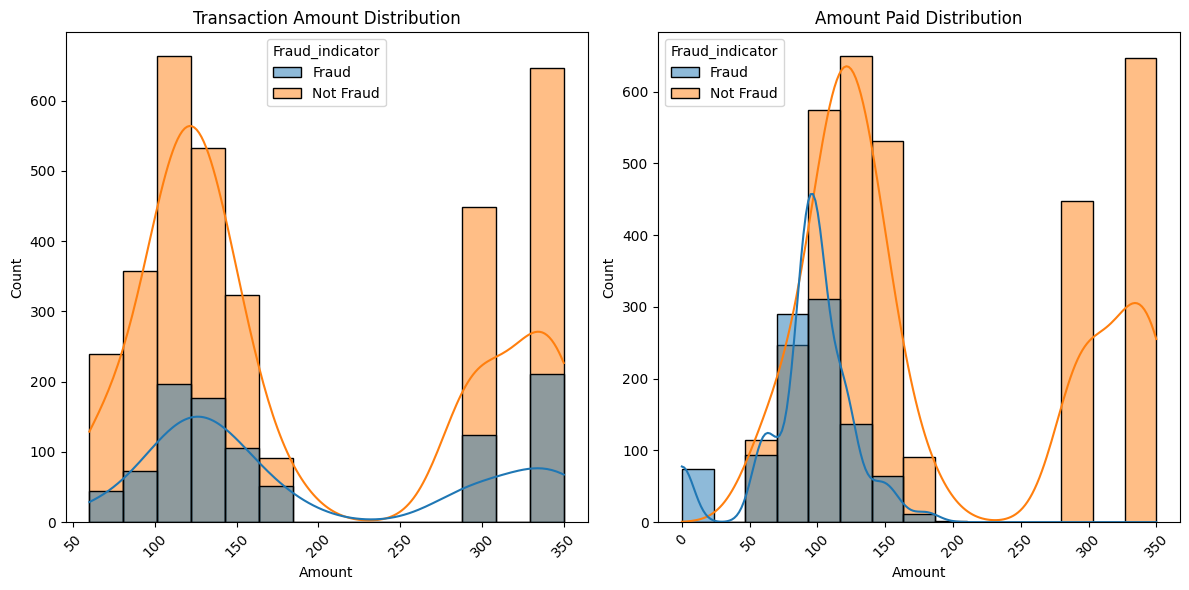

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(data=df, x='Transaction_Amount', hue='Fraud_indicator', kde=True, ax=axs[0])
axs[0].set_title('Transaction Amount Distribution')
sns.histplot(data=df, x='Amount_paid', hue='Fraud_indicator', kde=True, ax=axs[1])
axs[1].set_title('Amount Paid Distribution')
for ax in axs:
    ax.set_xlabel('Amount')
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

### Timestamp Column Typecasting to Datetime from object

In [9]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [10]:
print(df['Timestamp'].dtype)

datetime64[ns]


In [25]:
df.head(1)

,Transaction_ID,Timestamp,Vehicle_Type,FastagID,TollBoothID,Lane_Type,Vehicle_Dimensions,Transaction_Amount,Amount_paid,Geographical_Location,Vehicle_Speed,Vehicle_Plate_Number,Fraud_indicator
0,1,2023-01-06 11:20:00,Bus,FTG-001-ABC-121,A-101,Express,Large,350,120,"13.059816123454882, 77.77068662374292",65,KA11AB1234,Fraud


### Distribution Analysis:

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4286 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Transaction_ID         4286 non-null   int64         
 1   Timestamp              4286 non-null   datetime64[ns]
 2   Vehicle_Type           4286 non-null   object        
 3   FastagID               4286 non-null   object        
 4   TollBoothID            4286 non-null   object        
 5   Lane_Type              4286 non-null   object        
 6   Vehicle_Dimensions     4286 non-null   object        
 7   Transaction_Amount     4286 non-null   int64         
 8   Amount_paid            4286 non-null   int64         
 9   Geographical_Location  4286 non-null   object        
 10  Vehicle_Speed          4286 non-null   int64         
 11  Vehicle_Plate_Number   4286 non-null   object        
 12  Fraud_indicator        4286 non-null   object        
dtypes: datet

In [27]:
object_columns = df.select_dtypes(include=['object']).columns.to_list()
int_columns = df.select_dtypes(include=['int64']).columns.to_list()

In [28]:
object_columns.remove('FastagID') 
object_columns.remove('Geographical_Location')
object_columns.remove('Vehicle_Plate_Number')  

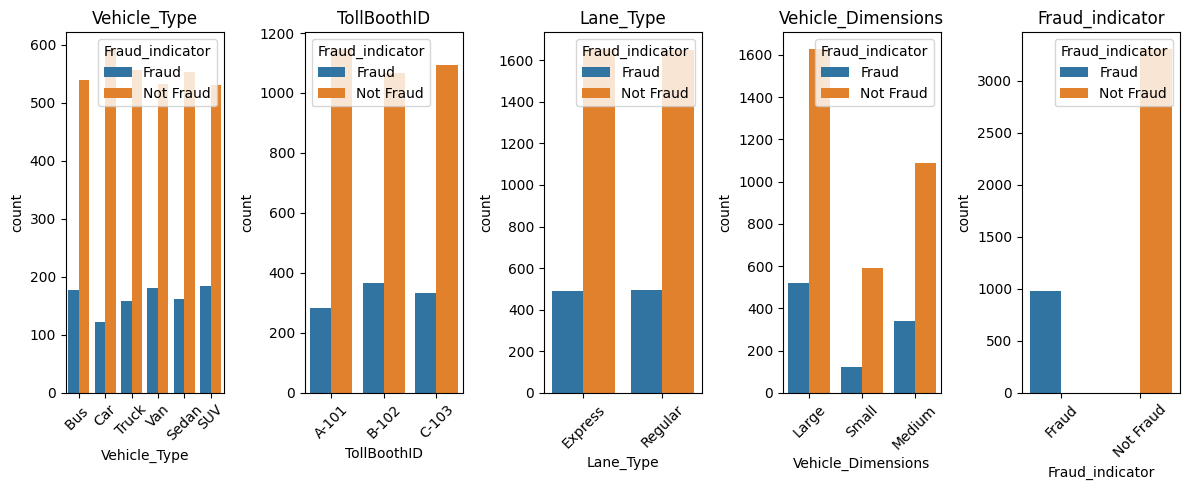

In [29]:
fig, axs = plt.subplots(1, len(object_columns), figsize=(12, 5))
for i, col in enumerate(object_columns):
    sns.countplot(x=col, data=df, ax=axs[i],hue='Fraud_indicator')
    axs[i].set_title(f'{col}')
    axs[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [30]:
int_columns.remove('Transaction_ID')

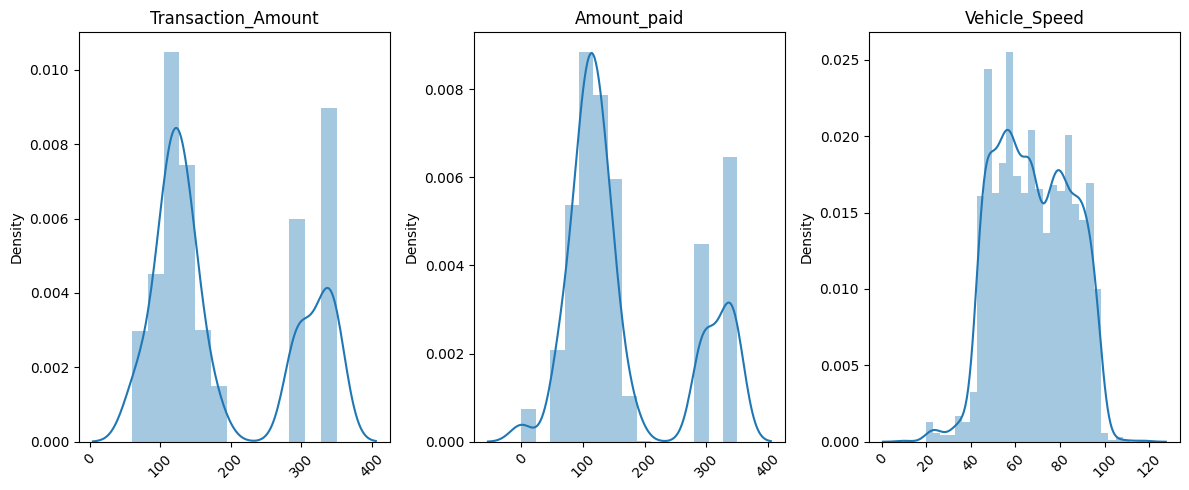

In [31]:
fig, axs = plt.subplots(1, len(int_columns), figsize=(12, 5))
for i, col in enumerate(int_columns):
    sns.distplot(x=df[col], ax=axs[i],kde=True)
    axs[i].set_title(f'{col}')
    axs[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [32]:
df.columns

Index(['Transaction_ID', 'Timestamp', 'Vehicle_Type', 'FastagID',
       'TollBoothID', 'Lane_Type', 'Vehicle_Dimensions', 'Transaction_Amount',
       'Amount_paid', 'Geographical_Location', 'Vehicle_Speed',
       'Vehicle_Plate_Number', 'Fraud_indicator'],
      dtype='object')

1. Transaction_ID: Unless there's a specific reason to believe that transaction IDs have a direct impact on fraud, they are usually unique identifiers and do not contribute to fraud prediction.
2. FastagID: Fastag IDs are likely to be unique identifiers and might not be directly related to fraud detection unless there's additional context or analysis involved.
3. Vehicle_Plate_Number: Similar to transaction IDs and Fastag IDs, vehicle plate numbers are typically unique identifiers and are not directly correlated with fraud.

These column are not directly correlated from target so, i directly drop it. 

In [33]:
df.drop(columns=['Transaction_ID','FastagID','Vehicle_Plate_Number'], inplace=True)

<Axes: >

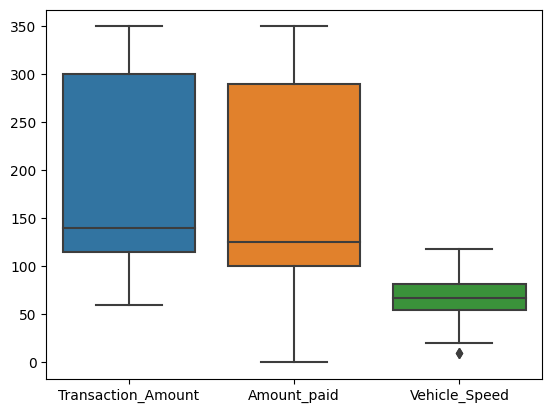

In [34]:
sns.boxplot(df)

No. Outlier are present

<Axes: >

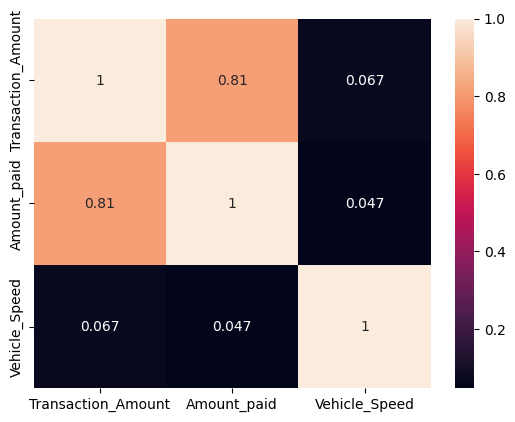

In [35]:
sns.heatmap(df[int_columns].corr(),annot=True)

In [11]:
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.strftime('%B') 
df['Day'] = df['Timestamp'].dt.strftime('%A') 
df['Hour'] = df['Timestamp'].dt.hour

In [37]:
datetime_columns=['Year','Month','Day','Hour']

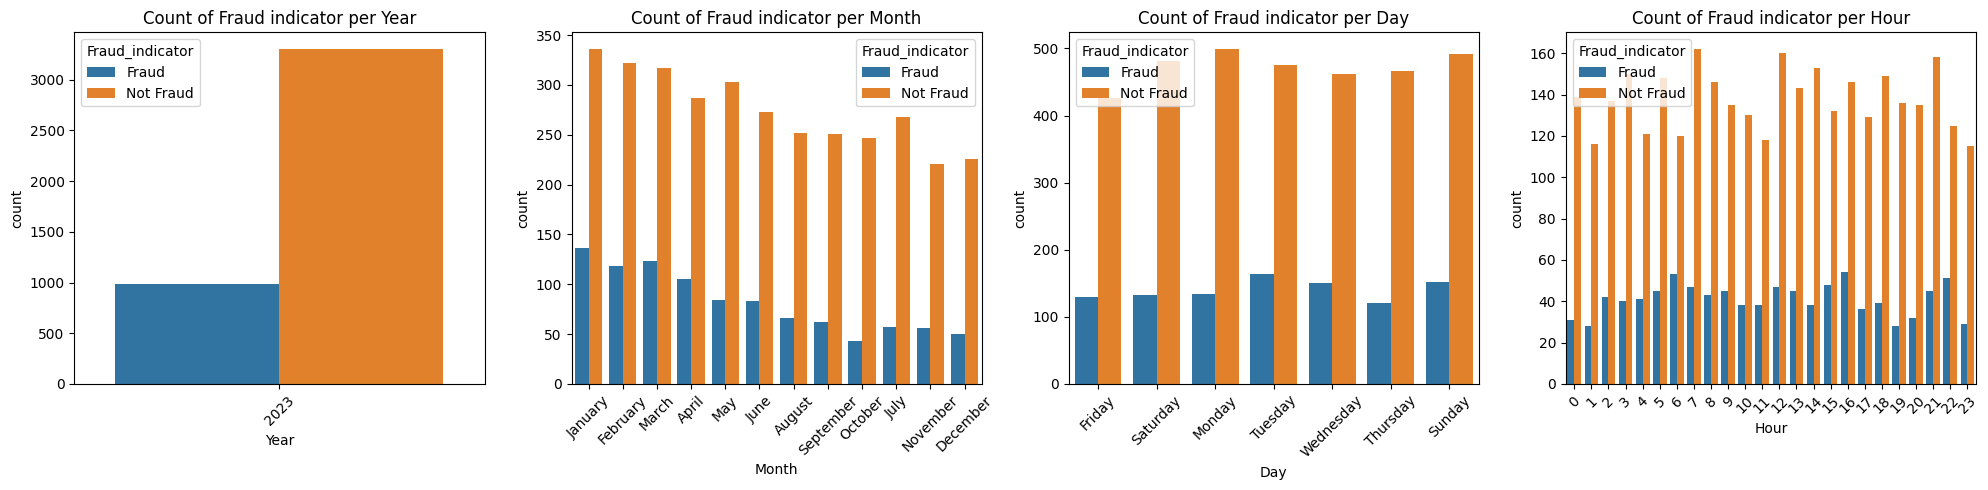

In [38]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i, col in enumerate(datetime_columns):
    sns.countplot(data=df, x=col, hue='Fraud_indicator', ax=axs[i])
    axs[i].set_title(f'Count of Fraud indicator per {col}')
    axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

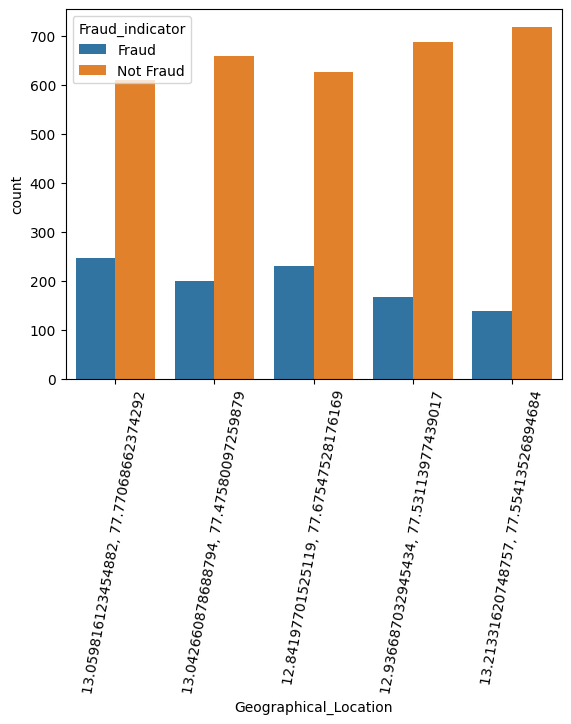

In [39]:
sns.countplot(data=df, x='Geographical_Location', hue='Fraud_indicator',)
plt.xticks(rotation=80)
plt.show()

I'm not removing the 'Timestamp' and 'Geographical_Location' columns because they play a minor role. Even though there's only a slight change in month, day, and hour, as well as across different locations, they still provide valuable insights.

In [12]:
df.drop(columns=['Timestamp'], inplace=True)

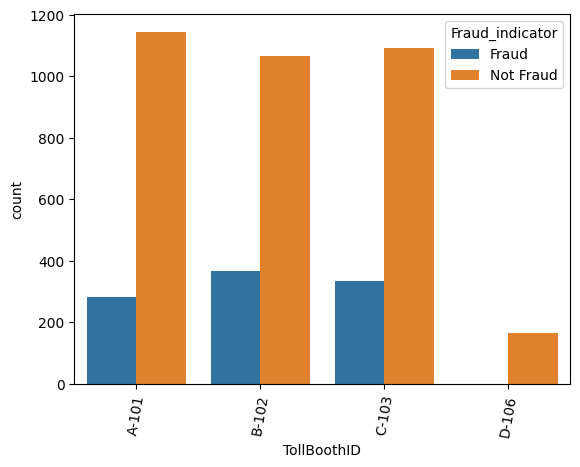

In [13]:
sns.countplot(data=df, x='TollBoothID', hue='Fraud_indicator',)
plt.xticks(rotation=80)
plt.show()

I removed the 'TollBoothID' column because all the toll booths listed in the dataset show almost the same frequency of fraud and non-fraud occurrences.

In [42]:
df.drop(columns=['TollBoothID'], inplace=True)

In [43]:
df.head(2)

,Vehicle_Type,Lane_Type,Vehicle_Dimensions,Transaction_Amount,Amount_paid,Geographical_Location,Vehicle_Speed,Fraud_indicator,Year,Month,Day,Hour
0,Bus,Express,Large,350,120,"13.059816123454882, 77.77068662374292",65,Fraud,2023,January,Friday,11
1,Car,Regular,Small,120,100,"13.059816123454882, 77.77068662374292",78,Fraud,2023,January,Saturday,14


In [14]:
X=df.drop('Fraud_indicator' ,axis=1)
y=df['Fraud_indicator'].map({'Not Fraud': 0, 'Fraud': 1})

In [15]:
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()

In [16]:
models = [
    ("Logistic Regression", LogisticRegression()),
    ("Support Vector Machines (SVM)", SVC()),
    ("Random Forest", RandomForestClassifier()),
    ("Gradient Boosting Machines (XGBoost)", XGBClassifier()),
    ("K-Nearest Neighbors (KNN)", KNeighborsClassifier()),
    ("Decision Trees", DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier()),
    ("Extra Trees", ExtraTreesClassifier()),
    ("Ensemble Methods (AdaBoost)", AdaBoostClassifier()),
    (
        "Ensemble Methods (Voting Classifier)",
        VotingClassifier(
            estimators=[
                ("lr", LogisticRegression()),
                ("svm", SVC()),
                ("rf", RandomForestClassifier()),
            ]
        ),
    ),
    (
        "Ensemble Methods (Bagging)",
        BaggingClassifier(base_estimator=DecisionTreeClassifier()),
    ),
    ("Ensemble Methods (Gradient Boosting)", GradientBoostingClassifier()),
]

In [17]:
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore',sparse=False,drop='first'), categorical_cols),
    ('num', StandardScaler(), numerical_cols)
])
smote = SMOTE(random_state=42)

In [112]:
def evaluate_classification_model(model_name, preprocessor, smote, model, X_train, y_train, X_test, y_test):
    # Fit the preprocessor to the training data
    X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)

    # Apply SMOTE to the preprocessed training data
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

    # Fit the model to the resampled data
    model.fit(X_train_resampled, y_train_resampled)

    # Predictions
    y_train_pred = model.predict(X_train_resampled)
    y_test_pred = model.predict(preprocessor.transform(X_test))

    # Print training classification report and confusion matrix
    print(f"Training Report for {model_name}:")
    print(classification_report(y_train_resampled, y_train_pred))
    print(f"Training Confusion Matrix for {model_name}:")
    print(confusion_matrix(y_train_resampled, y_train_pred))

    # Print testing classification report and confusion matrix
    print(f"Testing Report for {model_name}:")
    print(classification_report(y_test, y_test_pred))
    print(f"Testing Confusion Matrix for {model_name}:")
    print(confusion_matrix(y_test, y_test_pred))

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [115]:
for model_name, model in models:
    evaluate_classification_model(model_name, preprocessor, smote, model, X_train, y_train, X_test, y_test)

Training Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      2638
           1       1.00      0.95      0.97      2638

    accuracy                           0.97      5276
   macro avg       0.98      0.97      0.97      5276
weighted avg       0.98      0.97      0.97      5276

Training Confusion Matrix for Logistic Regression:
[[2637    1]
 [ 131 2507]]
Testing Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       665
           1       0.99      0.91      0.95       193

    accuracy                           0.98       858
   macro avg       0.98      0.95      0.97       858
weighted avg       0.98      0.98      0.98       858

Testing Confusion Matrix for Logistic Regression:
[[664   1]
 [ 18 175]]
Training Report for Support Vector Machines (SVM):
              precision    recall  f1-score   support

        

Based on the evaluation metrics of accuracy, precision, recall, and F1-score on both training and test data, here is the list of top-performing models:

1. **Gradient Boosting Machines (XGBoost):** High precision and recall on both training and testing sets indicate it is the best performer, with very few misclassifications.
2. **Bagging Classifier:** Also shows excellent performance with minimal misclassifications on the test set.
3. **Decision Trees:** Strong performance, but slightly more misclassifications compared to Bagging Classifier.
4. **Gradient Boosting Classifier:** Good performance with some misclassifications in the training and testing sets.
5. **Random Forest:** Strong training performance but slightly weaker testing performance compared to the top models.

Overall, **XGBoost** stands out as the most balanced and robust model among the top performers, followed closely by **Bagging Classifier** and **Decision Trees**.

In [18]:
xgb_model = XGBClassifier()

In [21]:
X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)

    # Apply SMOTE to the preprocessed training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

    # Fit the model to the resampled data
xgb_model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [23]:
y_train_resampled

0       0
1       1
2       1
3       1
4       1
       ..
5533    1
5534    1
5535    1
5536    1
5537    1
Name: Fraud_indicator, Length: 5538, dtype: int64

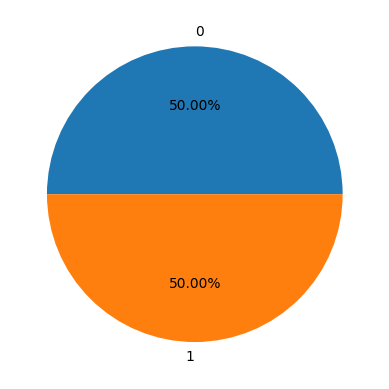

In [27]:
plt.pie(x=y_train_resampled.value_counts().values, labels=y_train_resampled.value_counts().index, autopct="%1.2f%%")
plt.show()

In [122]:
# Predict on training and testing data
y_train_pred = xgb_model.predict(X_train_preprocessed)
y_test_pred = xgb_model.predict(preprocessor.transform(X_test))

# Print training classification report
print("Training Report for XGBoost")
print(classification_report(y_train, y_train_pred))
print("Training Confusion Matrix for XGBoost")
print(confusion_matrix(y_train, y_train_pred))

# Print testing classification report
print("Testing Report for XGBoost")
print(classification_report(y_test, y_test_pred))
print("Testing Confusion Matrix for XGBoost")
print(confusion_matrix(y_test, y_test_pred))

Training Report for XGBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2638
           1       1.00      1.00      1.00       790

    accuracy                           1.00      3428
   macro avg       1.00      1.00      1.00      3428
weighted avg       1.00      1.00      1.00      3428

Training Confusion Matrix for XGBoost
[[2638    0]
 [   0  790]]
Testing Report for XGBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       665
           1       1.00      0.98      0.99       193

    accuracy                           1.00       858
   macro avg       1.00      0.99      0.99       858
weighted avg       1.00      1.00      1.00       858

Testing Confusion Matrix for XGBoost
[[665   0]
 [  3 190]]


In [98]:
param_grid = {
    'XGBoost__max_depth': [3, 4, 5],
    'XGBoost__min_child_weight': [1, 3, 5],
    'XGBoost__gamma': [0.0, 0.1, 0.2, 0.3],
    'XGBoost__subsample': [0.8, 0.9, 1.0],
    'XGBoost__colsample_bytree': [0.8, 0.9, 1.0],
    'XGBoost__reg_alpha': [0.01, 0.1, 1.0]
}

In [123]:
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1)

In [124]:
grid_search.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'XGBoost__colsample_bytree': [0.8, 0.9, 1.0],
                         'XGBoost__gamma': [0.0, 0.1, 0.2, 0.3],
                         'XGBoost__max_depth': [3, 4, 5],
                         'XGBoost__min_child_weight': [1, 3, 5],
                         'XGBoost__reg_alpha': [0.01, 0.1, 1.0],
                         'XGBoost__subsample': [0.8, 0.9, 1.0]},
             scoring='accuracy', verbose=1)

In [125]:
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: ", grid_search.best_score_)

Best parameters found:  {'XGBoost__colsample_bytree': 0.8, 'XGBoost__gamma': 0.0, 'XGBoost__max_depth': 3, 'XGBoost__min_child_weight': 1, 'XGBoost__reg_alpha': 0.01, 'XGBoost__subsample': 0.8}
Best cross-validation accuracy:  0.9963995404279764


In [128]:
best_model = grid_search.best_estimator_
print(best_model)

XGBClassifier(XGBoost__colsample_bytree=0.8, XGBoost__gamma=0.0,
              XGBoost__max_depth=3, XGBoost__min_child_weight=1,
              XGBoost__reg_alpha=0.01, XGBoost__subsample=0.8, base_score=None,
              booster=None, callbacks=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, ...)


In [129]:
y_train_pred = best_model.predict(X_train_preprocessed)
y_test_pred = best_model.predict(preprocessor.transform(X_test))
    # Print classification report
print("Training Report")
print(f"{model_name} Classification Report:")
print(classification_report(y_train, y_train_pred))

    # Print confusion matrix
print(f"{model_name} Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))
print("Test Report")
    # Print classification report
print(f"{model_name} Classification Report:")
print(classification_report(y_test, y_test_pred))

    # Print confusion matrix
print(f"{model_name} Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

Training Report
Ensemble Methods (Gradient Boosting) Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2638
           1       1.00      1.00      1.00       790

    accuracy                           1.00      3428
   macro avg       1.00      1.00      1.00      3428
weighted avg       1.00      1.00      1.00      3428

Ensemble Methods (Gradient Boosting) Confusion Matrix:
[[2638    0]
 [   0  790]]
Test Report
Ensemble Methods (Gradient Boosting) Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       665
           1       1.00      0.98      0.99       193

    accuracy                           1.00       858
   macro avg       1.00      0.99      0.99       858
weighted avg       1.00      1.00      1.00       858

Ensemble Methods (Gradient Boosting) Confusion Matrix:
[[665   0]
 [  3 190]]


In [131]:
import pickle

In [132]:
with open('xgb_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

In [130]:
X_test.head(1)

,Vehicle_Type,Lane_Type,Vehicle_Dimensions,Transaction_Amount,Amount_paid,Geographical_Location,Vehicle_Speed,Year,Month,Day,Hour
4366,Van,Express,Medium,120,120,"12.936687032945434, 77.53113977439017",44,2023,September,Wednesday,11
